In [1]:
#Importing dependencies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import re
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
#Reading in data
df = pd.read_stata(r'C:\Users\Dave Work\OneDrive - University of Texas Southwestern\UpFrontSurgery\020320 Surg Alone Rectal.dta')
df = df.filter(['RX_SUMM_SYSTEMIC_SUR_SEQ','RX_SUMM_RADIATION', 'RX_SUMM_SURGRAD_SEQ',
                                           'RX_SUMM_CHEMO',  'SEX','MED_INC_QUAR_12', 'AGE',
                                           'PUF_CASE_ID', 'raceb', 'TNM_CLIN_STAGE_GROUP','TNM_PATH_STAGE_GROUP','SEQUENCE_NUMBER', 'HISTOLOGY', 'RX_SUMM_SURG_PRIM_SITE', 'YEAR_OF_DIAGNOSIS', 'FACILITY_TYPE_CD', 'INSURANCE_STATUS', 'CDCC_TOTAL_BEST', 'DX_DEFSURG_STARTED_DAYS', 'CLASS_OF_CASE'])
df = df.dropna()

In [3]:
#Cleaning up data

#Filtering, removing people with unknown chemo or radiation data or interoperative
df2 = df[(df.RX_SUMM_SYSTEMIC_SUR_SEQ != 6)& 
    (df.RX_SUMM_SYSTEMIC_SUR_SEQ != 7)&
    (df.RX_SUMM_SYSTEMIC_SUR_SEQ != 9)&
    (df.RX_SUMM_RADIATION !=9)&
    (df.RX_SUMM_SURGRAD_SEQ != 6)&
    (df.RX_SUMM_SURGRAD_SEQ != 9)&
    (df.RX_SUMM_CHEMO != 88)&
    (df.RX_SUMM_CHEMO != 99)
    ]

#Dropping if stage is not 2 or 3, removing those whos primary tumor is not rectal, dropping if hist is not adenocarcenoma, drop if did not get definitive surg
df2 = df2.query('SEQUENCE_NUMBER in ["00","01"]')
df2 = df2.query('HISTOLOGY in [8140,8210,8260,8261,8262,8263,8480,8481]')
df2 = df2[df2.TNM_CLIN_STAGE_GROUP.str.contains("[23]",regex=True)]
df2 = df2.assign(stage= df2['TNM_CLIN_STAGE_GROUP'].str.get(0))
df2 = df2.query('RX_SUMM_SURG_PRIM_SITE in [40,30,50,60,70,80]')

#Making age groups
def age_group (row):
    if row['AGE'] <= 45 :
        return 0
    if row['AGE'] >= 46 and row['AGE'] < 65:
        return 1
    if row['AGE'] >= 65 :
        return 2
    return 3

df2['age_group'] = df2.apply (lambda row: age_group(row), axis=1)

#Create variable for switching facility
def treat_not_at_diag(row):
    if row['CLASS_OF_CASE'] in [0,22,20,21] :
        return "switched"
    return "stayed"

df2['treat_not_at_diag'] = df2.apply (lambda row: treat_not_at_diag(row), axis=1)


In [4]:
#Assigning neo-adjuvant if got rad OR chemo before surg
def surg4 (row):
        if row['RX_SUMM_SURGRAD_SEQ'] in [2,4] :
            return 0
        if row['RX_SUMM_SYSTEMIC_SUR_SEQ'] in [2,4] :
            return 0
        if row['RX_SUMM_SYSTEMIC_SUR_SEQ'] == 3 and row['RX_SUMM_RADIATION'] ==0 :
            return 1
        if row['RX_SUMM_SURGRAD_SEQ'] == 3 and row['RX_SUMM_CHEMO'] in [0,82,85,86,87] :
            return 1
        if row['RX_SUMM_SURGRAD_SEQ'] == 3 and row['RX_SUMM_SYSTEMIC_SUR_SEQ'] ==3 :
            return 1
        if row['RX_SUMM_RADIATION'] == 0 and row['RX_SUMM_CHEMO'] in [0,82,85,86,87] :
            return 1
        return 2
    
df2['surg4'] = df2.apply (lambda row: surg4(row), axis=1)
df2 = df2[(df2.surg4!= 2)]

In [9]:
#Logistic Regression for odds of upfront surgery

model = smf.logit(formula="surg4~ C(YEAR_OF_DIAGNOSIS) + C(stage) + C(MED_INC_QUAR_12) + C(INSURANCE_STATUS) + C(raceb) + C(CDCC_TOTAL_BEST) + C(SEX) + C(age_group) + C(FACILITY_TYPE_CD) + C(treat_not_at_diag)",data = df2).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.357226
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  surg4   No. Observations:                51562
Model:                          Logit   Df Residuals:                    51529
Method:                           MLE   Df Model:                           32
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.04841
Time:                        12:12:00   Log-Likelihood:                -18419.
converged:                       True   LL-Null:                       -19356.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.6476      0.116    -14.238      0.000      -1.874      -1.421
C(YEAR_OF_DIAGNOSIS)[T.2007]        -0.0483      0.069     -0.701      0.483      -0.183       0.087
C(YEAR_OF_DIAGNOSIS)[T.2008]         0.1261      0.065      1.947      0.052      -0.001       0.253
C(YEAR_OF_DIAGNOSIS)[T.2009]         0.0440      0.065      0.679      0.497      -0.083       0.171
C(YEAR_OF_DIAGNOSIS)[T.2010]        -0.1243      0.065     -1.907      0.056      -0.252       0.003
C(YEAR_OF_DIAGNOSIS)[T.2011]        -0.1997      0.065     -3.053      0.002      -0.328      -0.071
C(YEAR_OF_DIAGNOSIS)[T.2012]        -0.3545      0.066     -5.332      0.000      -0.485      -0.224
C(YEAR_OF_DIAGNOSIS)[T.2013]        -0.5359      0.068     -7.888      0.000      -0.669      -0.403
C(YEAR_OF_DIAGNOSIS)[T.2014]        -0.5978      0.068     -8.853      0.000      -0.730      -0.465
C(YEAR_OF_DIAGNOSIS)[T.2015]        -0.6441      0.069     -9.385      0.000      -0.779      -0.510
C(YEAR_OF_DIAGNOSIS)[T.2016]        -0.8873      0.073    -12.169      0.000      -1.030      -0.744
C(stage)[T.3]                       -0.2814      0.028    -10.228      0.000      -0.335      -0.228
C(MED_INC_QUAR_12)[T.2.0]            0.0103      0.043      0.241      0.809      -0.074       0.094
C(MED_INC_QUAR_12)[T.3.0]           -0.0224      0.043     -0.526      0.599      -0.106       0.061
C(MED_INC_QUAR_12)[T.4.0]            0.0004      0.042      0.010      0.992      -0.083       0.084
C(INSURANCE_STATUS)[T.1]            -0.0423      0.072     -0.590      0.556      -0.183       0.098
C(INSURANCE_STATUS)[T.2]            -0.0762      0.089     -0.856      0.392      -0.251       0.098
C(INSURANCE_STATUS)[T.3]             0.1078      0.079      1.367      0.172      -0.047       0.262
C(INSURANCE_STATUS)[T.4]             0.0069      0.148      0.046      0.963      -0.282       0.296
C(INSURANCE_STATUS)[T.9]             0.2417      0.134      1.798      0.072      -0.022       0.505
C(raceb)[T.2.0]                      0.0365      0.052      0.703      0.482      -0.065       0.138
C(raceb)[T.3.0]                      0.0507      0.076      0.671      0.502      -0.097       0.199
C(raceb)[T.4.0]                      0.1963      0.135      1.452      0.146      -0.069       0.461
C(CDCC_TOTAL_BEST)[T.1]              0.1867      0.035      5.366      0.000       0.119       0.255
C(CDCC_TOTAL_BEST)[T.2]              0.3222      0.064      4.998      0.000       0.196       0.449
C(CDCC_TOTAL_BEST)[T.3]              0.5732      0.093      6.158      0.000       0.391       0.756
C(SEX)[T.2]                          0.2653      0.028      9.597      0.000       0.211       0.319
C(age_group)[T.1]                    0.2378      0.066      3.624      0.000       0.109       0.366
C(age_group)[T.2]                    0.6588      0.074      8.947      0.000       0.514       0.803
C(FACILIT

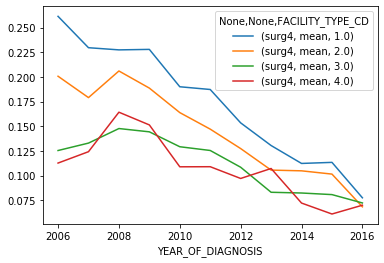

In [79]:
#below graphs in fewer steps but does not look as nice
#df3 = df2.filter(['YEAR_OF_DIAGNOSIS','FACILITY_TYPE_CD','surg4'])        
#df3.groupby(['YEAR_OF_DIAGNOSIS','FACILITY_TYPE_CD']).agg(['mean']).unstack().plot()

Text(0, 0.5, 'Proportion Receiving Upfront Surgery')

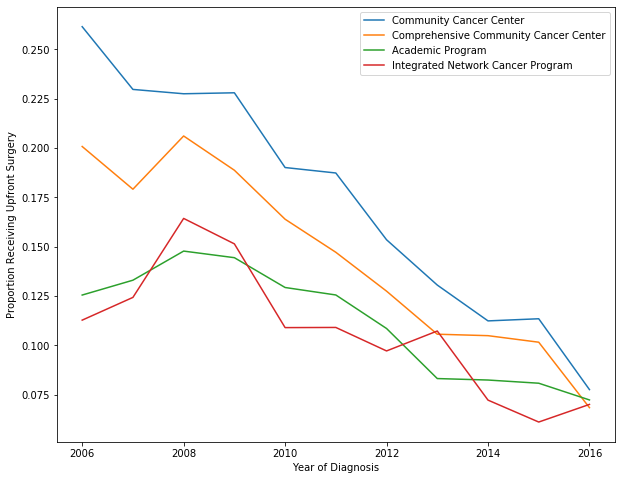

In [7]:
#Graphing proportion receiving upfront surg at different facility types over time
rcParams['figure.figsize'] = 10, 8

dfCC = df2.query('FACILITY_TYPE_CD==1').filter(['YEAR_OF_DIAGNOSIS','surg4']).groupby(['YEAR_OF_DIAGNOSIS']).agg(['mean'])
dfCCC = df2.query('FACILITY_TYPE_CD==2').filter(['YEAR_OF_DIAGNOSIS','surg4']).groupby(['YEAR_OF_DIAGNOSIS']).agg(['mean'])
dfA = df2.query('FACILITY_TYPE_CD==3').filter(['YEAR_OF_DIAGNOSIS','surg4']).groupby(['YEAR_OF_DIAGNOSIS']).agg(['mean'])
dfIN = df2.query('FACILITY_TYPE_CD==4').filter(['YEAR_OF_DIAGNOSIS','surg4']).groupby(['YEAR_OF_DIAGNOSIS']).agg(['mean'])

plt.plot(dfCC,label="Community Cancer Center")
plt.plot(dfCCC,label="Comprehensive Community Cancer Center")
plt.plot(dfA,label="Academic Program")
plt.plot(dfIN,label="Integrated Network Cancer Program")
plt.legend()
plt.xlabel("Year of Diagnosis")
plt.ylabel("Proportion Receiving Upfront Surgery")


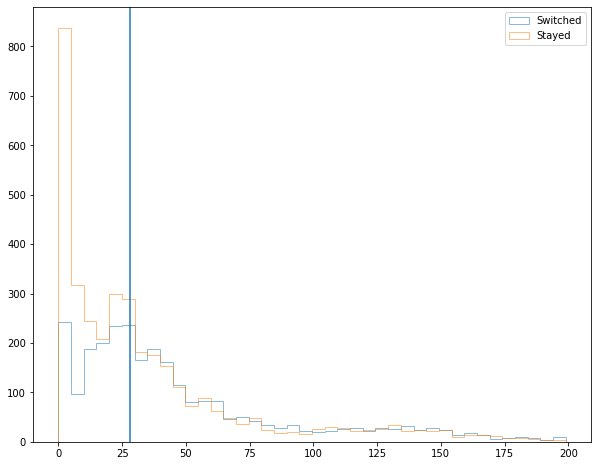

In [8]:
#What happened to people who got upfront surgery?

#Data frame that only includes people who got upfront surg
dfsurg = df2.query('surg4 == 1')

# Plotting surgery delay and switching facility
dfsurggraph = dfsurg.filter(['treat_not_at_diag','DX_DEFSURG_STARTED_DAYS']).query('DX_DEFSURG_STARTED_DAYS<200')
dfsurggraphswitch = dfsurggraph.query('treat_not_at_diag == "switched"')
dfsurggraphstay = dfsurggraph.query('treat_not_at_diag == "stayed"')
plt.hist(dfsurggraphswitch['DX_DEFSURG_STARTED_DAYS'], bins=40,fill=False,histtype='step',stacked=True,label="Switched",alpha=0.5)
plt.hist(dfsurggraphstay['DX_DEFSURG_STARTED_DAYS'], bins=40,fill=False,histtype='step',stacked=True,label="Stayed",alpha=0.5)
plt.legend()
plt.axvline(x=28)


In [27]:
# Multiomial logistic regression for different kinds of delays in pts who got upfront surg

#Making three groups for surgery delay
def delay(row):
    if row['DX_DEFSURG_STARTED_DAYS'] == 0 :
        return 0
    if row['DX_DEFSURG_STARTED_DAYS'] > 27 :
        return 3
    return 2

#MNLogistic
import statsmodels.api as sm
dfsurg['delay'] = dfsurg.apply (lambda row: delay(row), axis=1)
model_eqn = "delay~  C(CDCC_TOTAL_BEST) + C(FACILITY_TYPE_CD) + C(treat_not_at_diag)" 
model2 = sm.MNLogit.from_formula(model_eqn,dfsurg).fit()
print(model2.summary())


C:\Users\Dave Work\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.921201
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  delay   No. Observations:                 6409
Model:                        MNLogit   Df Residuals:                     6393
Method:                           MLE   Df Model:                           14
Date:                Tue, 19 May 2020   Pseudo R-squ.:                 0.02888
Time:                        11:20:47   Log-Likelihood:                -5904.0
converged:                       True   LL-Null:                       -6079.6
Covariance Type:            nonrobust   LLR p-value:                 2.344e-66
                         delay=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1505      0.126      9.14